In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib
import mod_trace
from ord2017 import ORD2017

In [2]:
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print('"%s" has been created.'%(path))
    else:
        print("The folder already exists.")

In [3]:
result_dir = './Results'
create_folder(result_dir)

The folder already exists.


In [4]:
'''
O'Hara CiPA v1.0 2017
'''
cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
end_time = 500
bcl = 1000
duration = 0.5
offset = 20

t_span = (0, end_time)
# t_eval = np.linspace(0, t_span[1], 5000)  

In [5]:
import simulator_myokit
'''
Simulation with Myokit
'''
start_time = time.time()

model_myokit, protocol_myokit, script = myokit.load("../../../mmt-model-files/ohara-cipa-v1-2017.mmt" )
protocol_myokit = myokit.pacing.blocktrain(bcl*100, duration, offset=offset) # period, duration, offset=0, level=1.0, limit=0
sim_myokit = simulator_myokit.Simulator(model_myokit, protocol_myokit, max_step=1.0, abs_tol=1e-08, rel_tol=1e-10, vhold=0)  # 1e-12, 1e-14  # 1e-08, 1e-10

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.343587875366211 seconds ---


In [6]:
y0_li = []
simulated_models_myokit = []
for name, mode in cell_types.items():    
    start_time = time.time()
    
    params = {         
        'cell.mode': mode,    
    }
    sim_myokit.set_simulation_params(params)
    y0_myokit = sim_myokit.pre_simulate(bcl*100, sim_type=1)
    y0_li.append(y0_myokit)
    d = sim_myokit.simulate(end_time, log_times=None)
    simulated_models_myokit.append(d)
    
    print("--- %s seconds ---"%(time.time()-start_time))

--- 0.0348055362701416 seconds ---
--- 0.03581857681274414 seconds ---
--- 0.03247332572937012 seconds ---


In [7]:
import simulator_scipy
'''
Simulation with BDF
'''
protocol = protocol_lib.PacingProtocol(level=1, start=offset, length=duration, period=bcl, multiplier=0, default_time_unit='ms')

model = ORD2017(protocol)
    
sim = simulator_scipy.Simulator(model)

simulated_models_BDF = []
for name, mode in cell_types.items(): 
    start_time = time.time()

    sim.model.change_cell(mode)        
    sim.model.y0[:-1] = y0_li[mode]    
    # y0 = sim.pre_simulate( pre_step=bcl*100, protocol='constant', v0=-8.80019046500000002e1)   
    # y0 = sim.pre_simulate( pre_step=bcl*100, protocol='pacing', v0=-8.80019046500000002e1)   
    sol = sim.simulate(t_span=t_span, t_eval=None, method='BDF', max_step=0.5, atol=1e-08, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10
    simulated_models_BDF.append(copy.copy(model))

    print("--- %s seconds ---"%(time.time()-start_time))

--- 3.0629210472106934 seconds ---
--- 3.1455554962158203 seconds ---
--- 3.126149892807007 seconds ---


In [8]:
# import simulator_euler
# '''
# Simulation with Euler
# '''
# protocol = protocol_lib.PacingProtocol(level=1, start=20, length=0.5, period=1000, multiplier=0, default_time_unit='ms')
# model = ORD2017(protocol, is_exp_artefact=False)
# sim = simulator_euler.Simulator(model)

# simulated_models_Euler = []
# for i, (name, mode) in enumerate(cells.items()): 
#     start_time = time.time()
    
#     sim.model.change_cell(mode)       
#     sim.model.y0[:-1] = y0_li[i]
#     sim.dt = 0.02
#     sim.simulate(end_time=end_time)      
#     simulated_models_Euler.append(copy.copy(model))
    
#     print("--- %s seconds ---"%(time.time()-start_time))

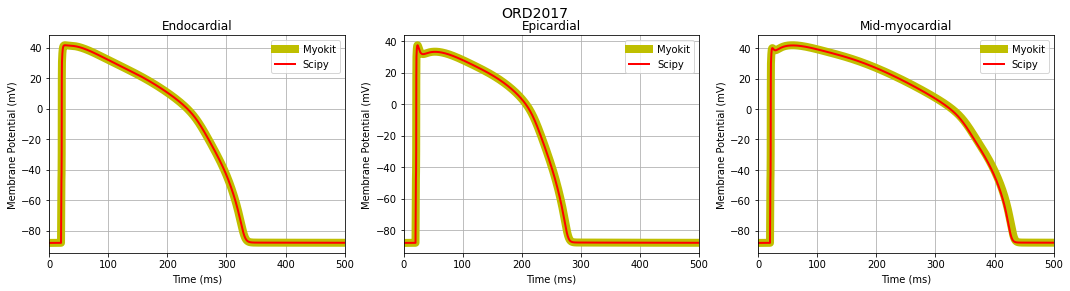

In [9]:
'''
Plot
'''
fig, axes = plt.subplots(1,3, figsize=(18,4))    
fig.suptitle(model.name, fontsize=14)
for name, mode in cell_types.items(): 
    myokit_m = simulated_models_myokit[mode]
    bdf_m = simulated_models_BDF[mode]      
    # euler_m = simulated_models_Euler[mode]
    
    axes[mode].set_title(name)
    axes[mode].set_xlim(bdf_m.times.min(), bdf_m.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    axes[mode].set_ylabel('Membrane Potential (mV)')  
    axes[mode].set_xlabel('Time (ms)')       
    axes[mode].plot( myokit_m['engine.time'], myokit_m['membrane.V'], label='Myokit', linewidth=8, color='y') 
    axes[mode].plot(bdf_m.times, bdf_m.V, label='Scipy', linewidth=2, color='r')   
    # axes[mode].plot(euler_m.times, euler_m.V, label='Euler', linewidth=2, color='k')   
        
    # textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], \
    #             GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    #     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
    #     fig1 = plt.gcf()
    axes[mode].legend()
    axes[mode].grid()
    
#     print(bdf.V)
#     print(euler.V)
#     print("-"*100)
    
plt.show()
fig.savefig(os.path.join(result_dir, "OHara2017_AP.jpg"), dpi=100)

In [10]:
print("Complete")

Complete
